In [4]:
!pip install emoji
!pip install soynlp
!pip install datasets
# !pip install transformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 6.6 MB/s eta 0:00:00a 0:00:01


In [2]:
from datasets import load_dataset

kmhas_dataset = load_dataset("jeanlee/kmhas_korean_hate_speech")

Generating train split:   0%|          | 0/78977 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8776 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/21939 [00:00<?, ? examples/s]

Dataset kmhas downloaded and prepared to /root/.cache/huggingface/datasets/jeanlee___kmhas/default/1.0.0/17406fbed45548c92e0795df0675e21fb2a09ceaa098bd5ff58c7fdc7f8a63d4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
import pandas as pd

train_kmhas_df = pd.DataFrame(kmhas_dataset['train'])
test_kmhas_df = pd.DataFrame(kmhas_dataset['test'])
valid_kmhas_df = pd.DataFrame(kmhas_dataset['validation'])

kmhas_df = pd.concat([train_kmhas_df, test_kmhas_df, valid_kmhas_df], ignore_index=True)
kmhas_df.to_excel('./kmhas.xlsx',index=False)
kmhas_df.sample(10)

,text,label
88073,중국어 선생 중국어 이상하던데...,[8]
51139,지들이 무식하고 못배워서 그른가??,[8]
73325,"""그렇게 남퇘지들 동숲 플미로 팔려고 줄서 있던거나 욕해라 ㅋ 이중잣대 오짐""","[1, 5]"
66808,"""지랄한다 애 뭔죄냐 아가..아줌마가 기도하마""",[3]
35354,보기 좋아요~,[8]
33812,부들이들이 몰려온다,[8]
26423,연좌죄 적용이냐? 갑오경장때 폐지됬는데 뭔 아들이 책임지냐,[8]
77595,"""베충 틀닥 수준 꼬라지하고는...ㅉㅉ""",[4]
91738,정권이 바뀌어도 바뀌는거 별로 없단걸 배웠다. 썩을!,[8]
59548,"""문재앙만 봐도 빨갱이 소굴인데 먼 시대타령이냐 넌 ㅋㅋ""",[2]


In [6]:
#     class_change_dict = {
#     0: "출신" ,1:"외모" , 2:"정치성향", 3:"혐오욕설",
#     4: "연령 차별", 5:"성차별" , 6:"인종차별", 7:"종교차별",
#     8: "일반 발언"
#     }
def kmhas2df(df):
    kmhas_df = df
    kmhas_df.rename(columns={'label': 'class'}, inplace=True)
    kmhas_df = kmhas_df[kmhas_df['class'].apply(lambda x: len(x) == 1)]
    kmhas_df.reset_index(drop=True,inplace=True)

    kmhas_df['class'] = kmhas_df['class'].apply(lambda x: x[0])
    
    return kmhas_df

kmhas_df = kmhas2df(kmhas_df)
kmhas_df.sample(10)

/tmp/ipykernel_26/607687010.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmhas_df['class'] = kmhas_df['class'].apply(lambda x: x[0])


,text,class
20346,군대가라고 난리치던 새끼들 어디갔노?,3
95797,"""문과스러운 댓글이네 (비하적의도 아님)""",8
68971,ㅋㅋㅋㅋ냄비만 태워먹고 라면에 밥말아먹는게 훨나음,8
21564,결혼률과 출산률이 떨어지고 있는 마당에 이런 프로그램은 없어져야 합니다.,8
84597,키스할라다 거부해서 흉기들고 깝쳤다던데 그렇게 하고싶음 업소가라,8
46684,김선아처럼 팔색조같은 여배우 보기드물다. 사랑한다 김선아,8
42213,와...존못. 세상에 뭐 저런와꾸로ㅋㅋㅋㅋㅋㅋㅋ,1
59600,안바쁘면 계속 나왔음 좋겠당^^아기도 이쁘고,8
23807,문까지 걸어잠그고 20명이나 되는 남자들이 추행만햇어? 음 고자색기들인가,3
77936,에이미 뚱뚱이미국에서 그지처럼 산다는대 ㅋㅋ,1


In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "beomi/KcELECTRA-small-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=9, output_hidden_states=True)

# set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/450k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-small-v2022 and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [8]:
batch_size =  32
learning_rate =  5e-5
num_epochs = 10
num_training_steps = 5000

In [9]:
from torch.utils.data import DataLoader, Dataset

# Custom Dataset 클래스
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        return text, label

my_dataset = MyDataset(kmhas_df)
train_dataloader = DataLoader(my_dataset, shuffle=True, batch_size=batch_size)

In [10]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=learning_rate)

num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [11]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    print(epoch)
    for texts, labels in train_dataloader:
        # make inputs
        inputs = tokenizer(texts, padding=True, return_tensors='pt')
        inputs['labels'] = torch.tensor(labels)
        
        inputs = {k: v.to(device) for k,v in inputs.items()}
        
        
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/30030 [00:00<?, ?it/s]

0


/tmp/ipykernel_26/950733730.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs['labels'] = torch.tensor(labels)
/tmp/ipykernel_26/950733730.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs['labels'] = torch.tensor(labels)


1
2
3
4
5
6
7
8
9


In [12]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

model= model.to(device)
model.eval()

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [13]:
# 임베딩을 저장할 리스트 초기화
embeddings = []

train_dataloader = DataLoader(my_dataset, shuffle=False, batch_size=batch_size)
# 데이터 로더를 통해 배치 단위로 처리
for texts, labgel in train_dataloader:
    inputs = tokenizer(texts, padding=True, return_tensors='pt')
    inputs = {k: v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        cls_hidden_state = outputs.hidden_states[-1].cpu()
        mean_embedding = torch.mean(cls_hidden_state,dim=1).squeeze()
        embeddings.extend(mean_embedding)

In [14]:
my_df = pd.DataFrame({
  "sentence" : embeddings,
  "label": kmhas_df['class']
})
my_df.head()

,sentence,label
0,"[tensor(0.1808), tensor(0.0449), tensor(0.2843...",8
1,"[tensor(0.2606), tensor(-0.1448), tensor(0.964...",2
2,"[tensor(0.6180), tensor(0.5072), tensor(-0.411...",4
3,"[tensor(0.2566), tensor(0.4730), tensor(-0.310...",8
4,"[tensor(0.2790), tensor(0.2758), tensor(-0.241...",8


In [15]:
import numpy as np
size = len(my_df)
matrix = np.zeros((size, 256))

for idx, vectors in enumerate(my_df['sentence']):
    vector = np.array(vectors)
    matrix[idx] =vector 

class_list = my_df['label']

In [16]:
import re
import emoji
import numpy as np 
import pandas as  pd
import seaborn as sns
import sys, re, argparse
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import font_manager, rc

def visulize_sentences(title ,matrix, class_list, class_dict=None):
    
    vectors = matrix # 여기에 100차원 벡터 데이터를 입력하세요
    classes = class_list # 여기에 해당 벡터의 클래스 라벨(0에서 10 사이의 값)을 입력하세요
    
    if class_dict is not None:
        for idx, tmp_class in enumerate(classes):
            classes[idx] = class_dict[tmp_class]
        
    class_kind = len(set(classes))
    # t-SNE 임베딩 수행
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    vectors_tsne = tsne.fit_transform(vectors)

    # 시각화
    plt.figure(figsize=(20, 10))
    sns.scatterplot(
        x=vectors_tsne[:, 0], y=vectors_tsne[:, 1],
        hue=classes,
        palette=sns.color_palette("hsv", class_kind),
        legend="full",
        alpha=0.7
    )

    plt.title(title)
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/tmp/ipykernel_26/658824166.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classes[idx] = class_dict[tmp_class]
/tmp/ipykernel_26/658824166.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'normal' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  classes[idx] = class_dict[tmp_class]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 96085 samples in 0.018s...
[t-SNE] Computed neighbors for 96085 samples in 111.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 96085
[t-SNE] Computed conditional probabilities for sample 2000 / 96085
[t-SNE] Computed conditional probabilities for sample 3000 / 96085
[t-SNE] Computed conditional probabilities for sample 4000 / 96085
[t-SNE] Computed conditional probabilities for sample 5000 / 96085
[t-SNE] Computed conditional probabilities for sample 6000 / 96085
[t-SNE] Computed conditional probabilities for sample 7000 / 96085
[t-SNE] Computed conditional probabilities for sample 8000 / 96085
[t-SNE] Computed conditional probabilities for sample 9000 / 96085
[t-SNE] Computed conditional probabilities for sample 10000 / 96085
[t-SNE] Computed conditional probabilities for sample 11000 / 96085
[t-SNE] Computed conditional probabilities for sample 12000 / 96085
[t-SNE] Computed conditional probabilities for 

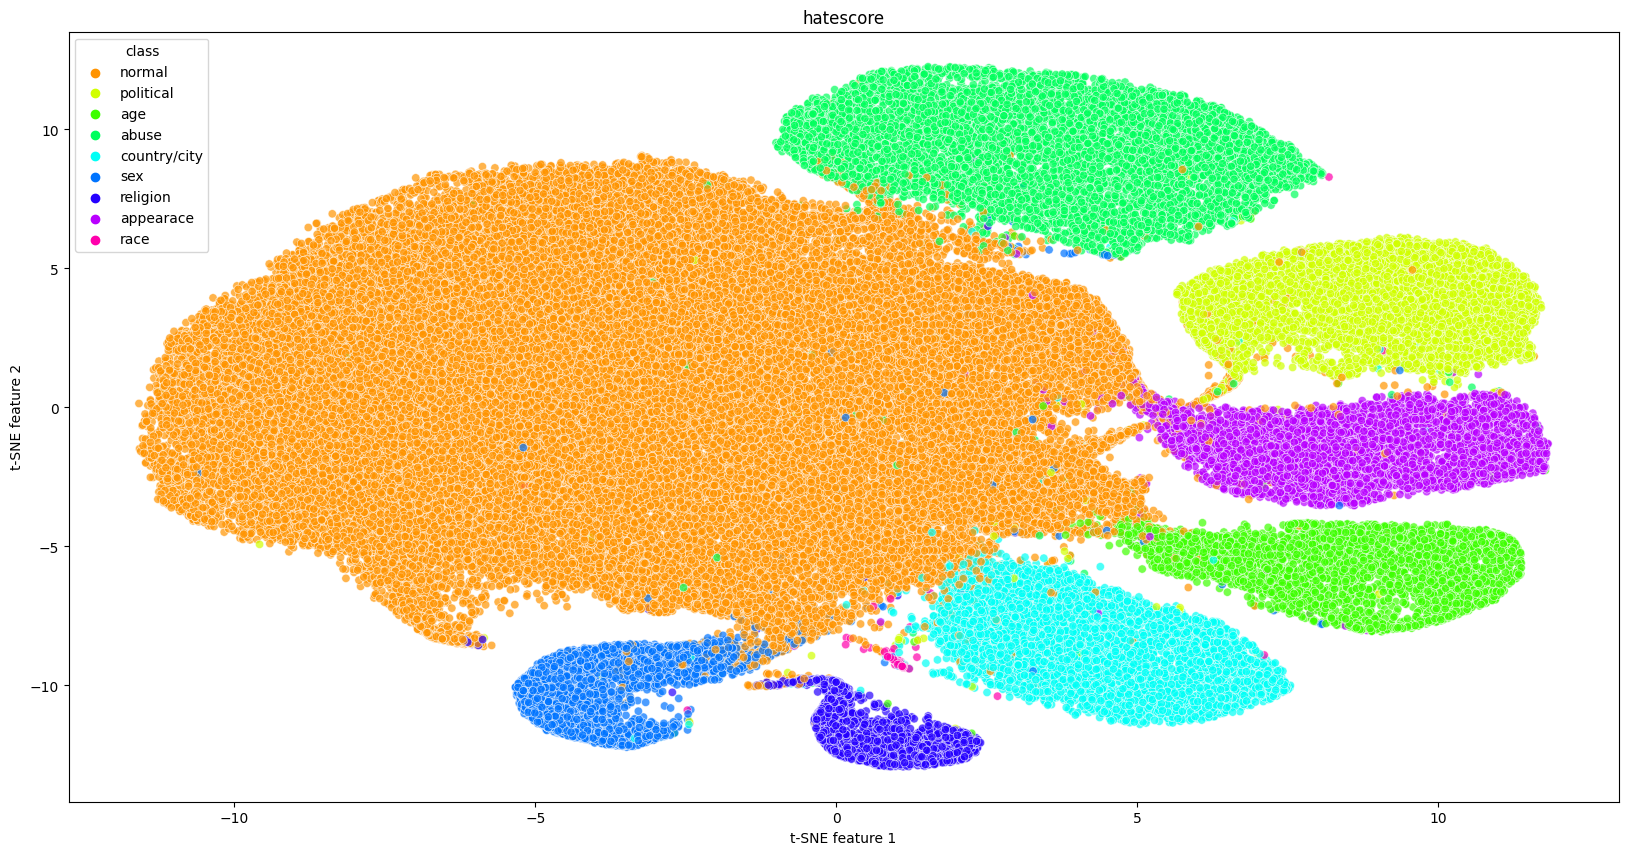

In [18]:
#     class_change_dict = {
#     0: "출신" ,1:"외모" , 2:"정치성향", 3:"혐오욕설",
#     4: "연령 차별", 5:"성차별" , 6:"인종차별", 7:"종교차별",
#     8: "일반 발언"
#     }

class_list = kmhas_df['class']
visulize_sentences("hatescore",matrix, class_list, {
    0:"country/city", 1:"appearace", 2:"political",
    3:"abuse", 4:"age", 5:"sex",
    6:"race", 7: "religion", 8: "normal"
})